In [6]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import time

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

digits_of_interest = [2, 3, 8, 9]
mask = np.isin(y_train, digits_of_interest)
x_train, y_train = x_train[mask], y_train[mask]
mask = np.isin(y_test, digits_of_interest)
x_test, y_test = x_test[mask], y_test[mask]

x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:1250], y_test[:1250]

x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

In [8]:
scaler = StandardScaler()
x_train_standardized = scaler.fit_transform(x_train)
x_test_standardized = scaler.transform(x_test)

# Apply PCA
n_components = 50 
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_standardized)
x_test_pca = pca.transform(x_test_standardized)

print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2f}")


Explained variance ratio: 0.62


In [9]:
# (a)
y_train = np.where(y_train == 2, 1, -1)
y_test = np.where(y_test == 2, 1, -1)

def prepare_matrices_pca(X, y, C):
    y = y.astype(float)
    K = X.dot(X.T)  # Linear kernel for PCA features
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones((X.shape[0], 1)))
    G = matrix(np.vstack((-np.eye(X.shape[0]), np.eye(X.shape[0]))))
    h = matrix(np.hstack((np.zeros(X.shape[0]), np.ones(X.shape[0]) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    return P, q, G, h, A, b

# Measure the training time
start_time = time.time()

# Train SVM using dual formulation with PCA features
C = 1.0
P, q, G, h, A, b = prepare_matrices_pca(x_train_pca, y_train, C)
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x']).flatten()

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Debugging: Print the alphas
print("Alphas:", alphas)

support_vector_indices = np.where(alphas > 1e-5)[0]
support_vectors = x_train_pca[support_vector_indices]
support_vector_labels = y_train[support_vector_indices]
support_vector_alphas = alphas[support_vector_indices]

print("Support Vector Indices:", support_vector_indices)
print("Support Vector Alphas:", support_vector_alphas)

def compute_intercept(support_vectors, support_vector_labels, support_vector_alphas, kernel_function):
    intercept = 0
    for i in range(len(support_vector_alphas)):
        intercept += support_vector_labels[i]
        intercept -= np.sum(support_vector_alphas * support_vector_labels * kernel_function(support_vectors, support_vectors[i]))
    if len(support_vector_alphas) > 0:
        intercept /= len(support_vector_alphas)
    else:
        intercept = 0  # Avoid division by zero
    return intercept

intercept = compute_intercept(support_vectors, support_vector_labels, support_vector_alphas, lambda x1, x2: np.dot(x1, x2))

def predict_pca(X, support_vectors, support_vector_labels, support_vector_alphas, intercept):
    predictions = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        prediction = 0
        for alpha, sv_y, sv in zip(support_vector_alphas, support_vector_labels, support_vectors):
            prediction += alpha * sv_y * np.dot(X[i], sv)
        predictions[i] = prediction
    return np.sign(predictions + intercept)

y_train_pred = predict_pca(x_train_pca, support_vectors, support_vector_labels, support_vector_alphas, intercept)
y_test_pred = predict_pca(x_test_pca, support_vectors, support_vector_labels, support_vector_alphas, intercept)

train_accuracy = np.mean(y_train == y_train_pred)
test_accuracy = np.mean(y_test == y_test_pred)

print(f"Training accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")

     pcost       dcost       gap    pres   dres
 0: -1.1133e+03 -1.3909e+04  9e+04  4e+00  3e-12
 1: -7.0875e+02 -9.2041e+03  2e+04  5e-01  3e-12
 2: -5.2661e+02 -5.1160e+03  8e+03  2e-01  2e-12
 3: -4.2678e+02 -3.9304e+03  6e+03  1e-01  1e-12
 4: -3.7624e+02 -1.5858e+03  2e+03  2e-02  1e-12
 5: -3.8926e+02 -9.0448e+02  6e+02  7e-03  1e-12
 6: -4.0437e+02 -7.9086e+02  5e+02  5e-03  1e-12
 7: -4.1693e+02 -7.0138e+02  3e+02  3e-03  1e-12
 8: -4.2595e+02 -6.5276e+02  3e+02  2e-03  1e-12
 9: -4.3293e+02 -6.2001e+02  2e+02  1e-03  1e-12
10: -4.4318e+02 -5.8107e+02  1e+02  8e-04  1e-12
11: -4.5057e+02 -5.5804e+02  1e+02  5e-04  1e-12
12: -4.5933e+02 -5.3431e+02  8e+01  3e-04  1e-12
13: -4.6290e+02 -5.1931e+02  6e+01  2e-04  1e-12
14: -4.6922e+02 -5.0606e+02  4e+01  8e-05  1e-12
15: -4.7250e+02 -4.9851e+02  3e+01  4e-05  1e-12
16: -4.7607e+02 -4.9254e+02  2e+01  2e-05  1e-12
17: -4.7795e+02 -4.8887e+02  1e+01  5e-06  2e-12
18: -4.7934e+02 -4.8698e+02  8e+00  2e-06  1e-12
19: -4.8098e+02 -4.85

Training accuracy: 0.97
Test accuracy: 0.97


In [10]:
# (b)
C = 0.01
svm_linear = SVC(C=C, kernel='linear')

# Measure the training time
start_time = time.time()
svm_linear.fit(x_train_pca, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Predict on the training set
y_train_pred = svm_linear.predict(x_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.2f}")

# Predict on the test set
y_test_pred = svm_linear.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.2f}")


Training time: 0.12 seconds
Training accuracy: 0.96
Test accuracy: 0.96


In [12]:
# (c)
def rbf_kernel_pca(x1, x2, gamma=0.05):
    if x1.ndim == 1:
        x1 = x1.reshape(1, -1)
    if x2.ndim == 1:
        x2 = x2.reshape(1, -1)
    squared_distances = np.sum((x1[:, np.newaxis, :] - x2[np.newaxis, :, :]) ** 2, axis=2)
    return np.exp(-gamma * squared_distances)

# Prepare matrices for RBF kernel
def prepare_matrices_rbf_pca(X, y, C, gamma):
    y = y.astype(float)
    K = rbf_kernel_pca(X, X, gamma)
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones((X.shape[0], 1)))
    G = matrix(np.vstack((-np.eye(X.shape[0]), np.eye(X.shape[0]))))
    h = matrix(np.hstack((np.zeros(X.shape[0]), np.ones(X.shape[0]) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    return P, q, G, h, A, b

# Compute the intercept term
def compute_intercept(support_vectors, support_vector_labels, support_vector_alphas, kernel_function):
    intercept = 0
    for i in range(len(support_vector_alphas)):
        intercept += support_vector_labels[i]
        intercept -= np.sum(support_vector_alphas * support_vector_labels * kernel_function(support_vectors, support_vectors[i]))
    if len(support_vector_alphas) > 0:
        intercept /= len(support_vector_alphas)
    else:
        intercept = 0  # Prevent division by zero if no support vectors found
    return intercept

C = 1.0
gamma = 0.05
start_time = time.time()
P, q, G, h, A, b = prepare_matrices_rbf_pca(x_train_pca, y_train, C, gamma)
sol = solvers.qp(P, q, G, h, A, b)
end_time = time.time()
training_time = end_time - start_time


alphas = np.array(sol['x']).flatten()

# Identify support vectors
support_vector_indices = np.where(alphas > 1e-5)[0]
support_vectors = x_train_pca[support_vector_indices]
support_vector_labels = y_train[support_vector_indices]
support_vector_alphas = alphas[support_vector_indices]

# Compute intercept term
intercept = compute_intercept(support_vectors, support_vector_labels, support_vector_alphas, lambda x1, x2: rbf_kernel_pca(x1, x2, gamma))

# Define prediction function for PCA features with RBF kernel
def predict_rbf_pca(X, support_vectors, support_vector_labels, support_vector_alphas, intercept, gamma):
    y_predict = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        s = 0
        for alpha, sv_y, sv in zip(support_vector_alphas, support_vector_labels, support_vectors):
            s += alpha * sv_y * rbf_kernel_pca(X[i:i+1], sv[np.newaxis, :], gamma)
        y_predict[i] = s
    return np.sign(y_predict + intercept)

# Compute training and testing accuracies
y_train_pred = predict_rbf_pca(x_train_pca, support_vectors, support_vector_labels, support_vector_alphas, intercept, gamma)
y_test_pred = predict_rbf_pca(x_test_pca, support_vectors, support_vector_labels, support_vector_alphas, intercept, gamma)

train_accuracy = np.mean(y_train == y_train_pred)
test_accuracy = np.mean(y_test == y_test_pred)

print(f"Training time: {training_time:.2f} seconds")
print(f"Training accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")


     pcost       dcost       gap    pres   dres
 0: -1.4813e+03 -8.7384e+03  3e+04  2e+00  3e-15
 1: -1.4124e+03 -4.7542e+03  3e+03  3e-13  8e-16
 2: -1.4741e+03 -1.7880e+03  3e+02  2e-13  2e-15
 3: -1.5195e+03 -1.5556e+03  4e+01  2e-14  6e-16
 4: -1.5251e+03 -1.5296e+03  4e+00  9e-14  5e-16
 5: -1.5258e+03 -1.5263e+03  5e-01  9e-14  4e-16
 6: -1.5259e+03 -1.5259e+03  4e-02  9e-14  4e-16
 7: -1.5259e+03 -1.5259e+03  1e-03  6e-14  4e-16
Optimal solution found.


/var/folders/0y/rkt1cks911v4smbrjw1q78v80000gn/T/ipykernel_68798/1783404806.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_predict[i] = s


Training time: 135.13 seconds
Training accuracy: 1.00
Test accuracy: 0.75


In [13]:
# (d)
C = 1.0
gamma = 0.05
svm_rbf = SVC(C=C, kernel='rbf', gamma=gamma)

# Measure the training time
start_time = time.time()
svm_rbf.fit(x_train_pca, y_train)
end_time = time.time()
training_time = end_time - start_time


# Predict on the training set
y_train_pred = svm_rbf.predict(x_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.2f}")

# Predict on the test set
y_test_pred = svm_rbf.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.2f}")

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.05, 0.1, 0.5]
}

grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)

# Measure the tuning time
start_time = time.time()
grid_search.fit(x_train_pca, y_train)
end_time = time.time()
tuning_time = end_time - start_time
print(f"Hyperparameter tuning time: {tuning_time:.2f} seconds")
print(f"Training time: {training_time:.2f} seconds")

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(x_test_pca, y_test)
print(f"Test accuracy with best model: {test_accuracy:.2f}")

Training accuracy: 1.00
Test accuracy: 0.75
Hyperparameter tuning time: 58.85 seconds
Training time: 0.83 seconds
Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation accuracy: 0.96
Test accuracy with best model: 0.97


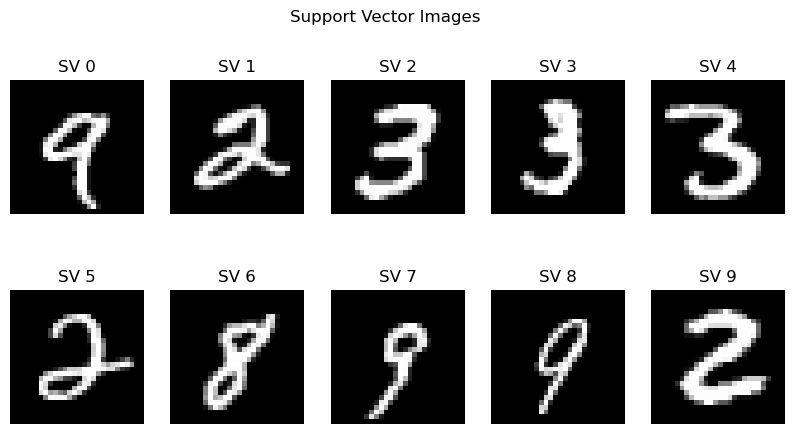

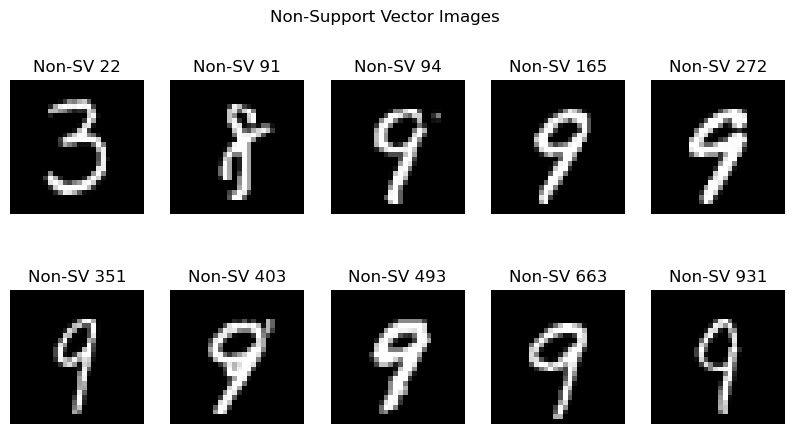

In [14]:
# Question 3

import matplotlib.pyplot as plt

support_vector_indices = np.where(alphas > 1e-5)[0]
support_vectors = x_train[support_vector_indices]  # Original images before PCA

# Plot support vector images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(support_vectors[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"SV {support_vector_indices[i]}")
    axes[i].axis('off')

plt.suptitle("Support Vector Images")
plt.show()

# Plot some non-support vector images for comparison
non_support_vector_indices = np.where(alphas <= 1e-5)[0]
non_support_vectors = x_train[non_support_vector_indices]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(non_support_vectors[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Non-SV {non_support_vector_indices[i]}")
    axes[i].axis('off')

plt.suptitle("Non-Support Vector Images")
plt.show()
